## This notebook follow the Keras functional API, however follows the implementation of MSE+, MAE+ and the same parameters and hiperpameters as the notebook 3.1 

In [1]:
import keras
import datetime
import tensorflow                       as tf
from tensorflow.keras.callbacks         import TensorBoard
from tensorflow.keras.layers            import Input, Lambda, Conv2D,Dropout,MaxPooling2D,Conv2DTranspose,concatenate,BatchNormalization
from tensorflow.keras.models            import Model
from tensorflow.keras.optimizers        import Adam
from keras.utils                        import plot_model
from tensorflow.keras                   import layers, models
from tensorflow.keras.losses            import mae
from pathlib                            import Path
from tensorflow.keras.callbacks         import LearningRateScheduler
import sys
import os
import numpy as np
import math
import random, time

import skimage                      as ski
from   skimage.filters              import threshold_otsu
from   skimage                      import io, color
from   skimage.color                import rgb2gray
from   skimage                      import filters
import cv2                          as cv
import matplotlib.pyplot            as plt
from decimal                        import Decimal


2024-11-05 07:14:00.998940: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-05 07:14:01.006248: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-05 07:14:01.014667: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-05 07:14:01.017185: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-05 07:14:01.023882: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Files path
directory= os.path.abspath("/home/guiomar/Desktop/CODES/DLCODES")

# Add directory to sys.path
sys.path.append(directory)

# import script
import param  

# Set the number of cores
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
num_threads = param.n_threads  
tf.config.threading.set_intra_op_parallelism_threads(num_threads)
tf.config.threading.set_inter_op_parallelism_threads(num_threads)


In [3]:
#Load the main directory
paths=param.list_paths 
for i,j in enumerate(paths):
    print(f'{i} => {j}')

# Defining amount of train,valid,test images
n_train=0.8;    n_valid=0.1;    n_test=0.1

# Defining a sample i.e.
n_sample=500                                        

# For resizing dimentions
h=128
w=256



0 => /home/guiomar/Desktop/CODES/Generation_Data/Proyecto_UNI/Geometry
1 => /home/guiomar/Desktop/CODES/Generation_Data/Proyecto_UNI/Magnitude
2 => /home/guiomar/Desktop/CODES/Generation_Data/Proyecto_UNI/Pression
3 => /home/guiomar/Desktop/CODES/Generation_Data/Proyecto_UNI/U001
4 => /home/guiomar/Desktop/CODES/Generation_Data/Proyecto_UNI/U002


# <span style="color:blue">2. Preprocessing </span>

In [4]:
# method for reading image    
def get_img(img_name):
    return ski.io.imread(img_name)
 
# method for turning to a grey or binary image 
def processing(image,option=True):
        x = get_img(image)  
        x = rgb2gray(x)       # It returns a grayscale image with floating point values in the range from 0 to 1
        x =cv.resize(x,(w,h)) # Reshape image 
    
        # Binary option otherwise gray
        if (option):
            x=ski.util.img_as_ubyte(x)  # Convert it back to the original data type and the data range back 0 to 255. 
                                        # It is often better to use image values represented by floating point values 
            best_value_threshold=np.round(filters.threshold_otsu(x)) #  Otsu’s method calculates an “optimal” threshold
            _,x= cv.threshold(x, best_value_threshold, 255, cv.THRESH_BINARY_INV)

        x=x[:, :, np.newaxis]
        return x
    
# method for splitting data
def split_data(path,n_sample,n_train,n_valid,n_test):
        
        files=sorted([os.path.join(path, fname) for fname in os.listdir(path) if fname.endswith(".png")])
        n_files=len(files)
        
        if(n_files>n_sample):
                print()
                print(' ######  \t Loaded ',n_sample,' of ',n_files,'from ',path,'\t #####\n')
                if (n_train + n_valid + n_test == 1.0):
        
                    n_train= math.floor(n_sample*n_train)
                    n_valid = math.floor(n_sample*n_valid) + n_train
                    n_test = math.floor(n_sample*n_test) + n_valid
              
                    (files_train,files_valid,files_tests) = (files[0:n_train], files[n_train:n_valid],files[n_valid:n_test])
                    
                return files_train,files_valid,files_tests

def arrays_img_processed(data,type=True): # True for Geometry 
    # begin in data[1:] 
    if type:
        list_arrays=[processing(image,option=True).astype(np.float32) for image in data[1:] ]
    else:
        list_arrays=[processing(image,option=False).astype(np.float32) for image in data[1:] ]
   
    return np.array(list_arrays) 


In [5]:
# Geometry
geo_train,geo_valid,geo_tests=split_data(paths[0],n_sample,n_train,n_valid,n_test)
geo_array_train=arrays_img_processed(geo_train)
geo_array_valid=arrays_img_processed(geo_valid)
geo_array_tests=arrays_img_processed(geo_tests)

# Magnitude
specific_tarjet=paths[1]

mag_train,mag_valid,mag_tests=split_data(specific_tarjet,n_sample,n_train,n_valid,n_test)
mag_array_train=arrays_img_processed(mag_train,False)
mag_array_valid=arrays_img_processed(mag_valid,False)
mag_array_tests=arrays_img_processed(mag_tests,False)

print(f'Training data for geometry: {geo_array_train.shape}')
print(f'Training data for magnitude: {mag_array_train.shape}')
print()
print(f'Valid data for geometry: {geo_array_valid.shape}')
print(f'Valid data for magnitude: {mag_array_valid.shape}')
print()
print(f'Test data for geometry: {geo_array_tests.shape}')
print(f'Test data for magnitude: {mag_array_tests.shape}')


 ######  	 Loaded  500  of  1001 from  /home/guiomar/Desktop/CODES/Generation_Data/Proyecto_UNI/Geometry 	 #####


 ######  	 Loaded  500  of  1001 from  /home/guiomar/Desktop/CODES/Generation_Data/Proyecto_UNI/Magnitude 	 #####

Training data for geometry: (399, 128, 256, 1)
Training data for magnitude: (399, 128, 256, 1)

Valid data for geometry: (49, 128, 256, 1)
Valid data for magnitude: (49, 128, 256, 1)

Test data for geometry: (49, 128, 256, 1)
Test data for magnitude: (49, 128, 256, 1)


# <span style="color:blue">3. Plot </span>
#### <span style="color:blue">Look at Data </span>

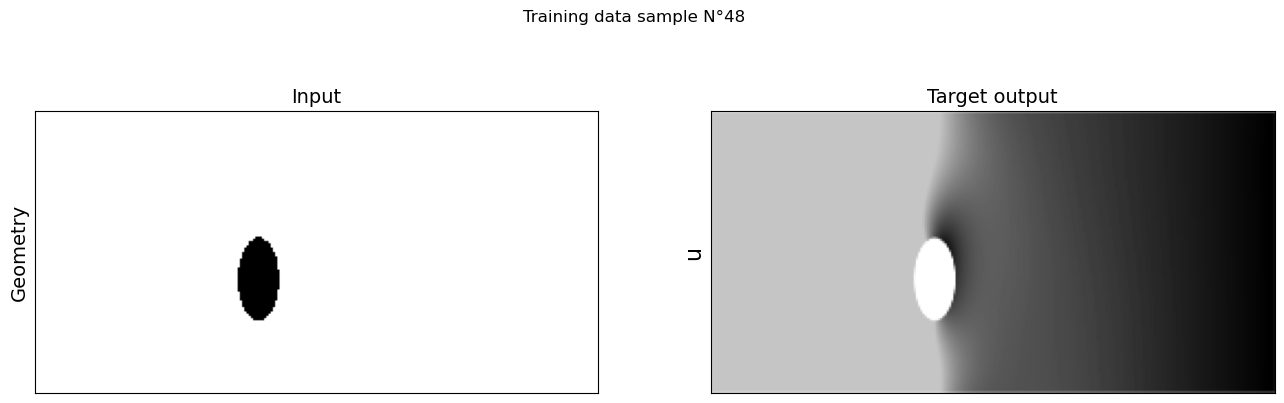

In [6]:
def plot_data(a1,a2,title=None,opt=None):
    if opt==None:
        fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
        ax1.set_xticks([]); ax1.set_yticks([]);
        ax2.set_xticks([]); ax2.set_yticks([]);
        ax1.imshow(a1,origin='upper',cmap='gray')
        ax1.set_title('Input',fontsize=14)
        #ax1.set_xlabel('Geometry')
        ax1.set_ylabel('Geometry',fontsize=14)
        ax2.imshow(a2,origin='upper',cmap='gray')
        ax2.set_title('Target output',fontsize=14)
        #ax2.set_xlabel('u')
        ax2.set_ylabel('u',fontsize=16)
        if title is not None: fig.suptitle(title)
    else:
        fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16, 5), sharey=True)
        ax1.set_xticks([]); ax1.set_yticks([]);
        ax2.set_xticks([]); ax2.set_yticks([]);
        ax1.imshow(a1,origin='upper',cmap='gray')
        ax1.set_title('Real',fontsize=14)
        #ax1.set_xlabel('Geometry')
        ax1.set_ylabel('u',fontsize=14)
        ax2.imshow(a2,origin='upper',cmap='gray')
        ax2.set_title('Prediction',fontsize=14)
        #ax2.set_xlabel('u')
        ax2.set_ylabel('u',fontsize=16)
        if title is not None: fig.suptitle(title)
        

NUM=random.sample(range(1, geo_array_train.shape[0]), 1)
plot_data( geo_array_train[NUM[0]],mag_array_train[NUM[0]], title=f"Training data sample N°{NUM[0]}") 

# <span style="color:blue">4. Setup</span>
### <span style="color:red">4.1 Hiperparameters</span>

In [7]:
num_classes=1
num_epochs =150
batch_size=50
patience=70   # How long to wait after last time validation loss improved
LR=0.01                                 
DECAY_RATE=0.015

   

### <span style="color:red">4.2 Learning rate</span>

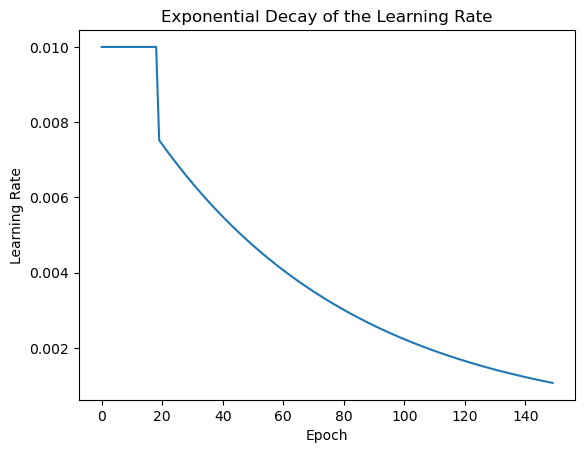

In [8]:
def exponential_decay(epoch,epochs=num_epochs,lr_ini=LR,decay_rate=DECAY_RATE):
    if epoch < epochs*0.125:
        return lr_ini
    else:
        return  lr_ini * np.exp(-decay_rate*epoch)

lr_scheduler = LearningRateScheduler(lambda epoch: exponential_decay(epoch))

epochs = np.arange(num_epochs)
learning_rates = [exponential_decay(epoch,num_epochs) for epoch in epochs]

plt.plot(epochs, learning_rates, label="Learning Rate")
plt.title("Exponential Decay of the Learning Rate")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.grid(False)
plt.show()   

### <span style="color:red">4.3 Loss function</span>
Definition of custom loss function MSE+
$$ MSE+ = \frac{1}{|D|} \sum_{P \in D} \frac{1}{|I_P|} \sum_{p \in I_P} ( \left\|u_p - \hat{u}_p \right\|_2^2 + \frac{\left\|u_p - \hat{u}_p \right\|_2}{ \left\|u_p \right\|_2 + 10^{-4}}) $$

$u_p$ es el vector de predicción de velocidad en el píxel $p$.

$\hat{u}_p$ es la velocidad de referencia en $p$.

$D$ es el conjunto de todos los obstáculos $P$ considerados.

$I_P$ es el conjunto de todos los píxeles $p$ que no están cubiertos por el obstáculo respectivo.
#### [See paper](https://etna.math.kent.edu/vol.56.2022/pp235-255.dir/pp235-255.pdf) 

In [9]:
def MSEplus(u_true, u_pred):
  
  Eps=1e-4
  tensor_shape= tf.shape(u_true)
  mask= tf.ones(tensor_shape, dtype=u_true.dtype)
  index = tf.where(u_true == 1)
  scalar_value = 0
  values = tf.fill([tf.shape(index)[0]], scalar_value)
  values = tf.cast(values, mask.dtype)
  mask=tf.tensor_scatter_nd_update(mask, index, values)

  u_true_masked = tf.multiply(u_true, mask) 
  u_pred_masked = tf.multiply(u_pred, mask)
 
  Ip=tf.boolean_mask(u_pred, mask)
  shape_tensor=tf.shape(Ip)
    
  Ip_value = tf.shape(shape_tensor)[0]

  #Ip_value = tf.get_static_value(shape_tensor)[0] 
  Ip_value = tf.cast(Ip_value, dtype=tf.float32)
  E_normL2=tf.sqrt(tf.reduce_sum(tf.square(u_true_masked - u_pred_masked)))
  E=tf.reduce_sum(tf.square(u_true_masked - u_pred_masked))
  u_pred_normL2=tf.sqrt(tf.reduce_sum(tf.square(u_pred_masked)))
  mse_loss = tf.reduce_sum(E + E_normL2 / (u_pred_normL2 + Eps))
  mse_loss=mse_loss/Ip_value
  return mse_loss 
  

In [10]:
def MAEplus(u_true, u_pred):
          # Regularizar  
          Eps=1e-4
        
          #get the dimensions of u_true
          tensor_shape= tf.shape(u_true)
        
          # create ones tensor under the given dimensions
          mask= tf.ones(tensor_shape, dtype=u_true.dtype)

          # get indices of u_true where pixels are of value 1
          index = tf.where(u_true == 1)
          scalar_value = 0
          values = tf.fill([tf.shape(index)[0]], scalar_value)
          values = tf.cast(values, mask.dtype)
        
          # Updating the ones and zeros mask: Zero pixels inside the obstacle
          mask=tf.tensor_scatter_nd_update(mask, index, values)

          # Application of the mask to real and predicted data
          u_true_masked = tf.multiply(u_true, mask) 
          u_pred_masked = tf.multiply(u_pred, mask)

          # Selects only the elements at positions where mask is True i.e 1.
          Ip=tf.boolean_mask(u_pred, mask)
          shape_tensor=tf.shape(Ip)
          Ip_value = tf.shape(shape_tensor)[0]

          #Ip_value = tf.get_static_value(shape_tensor)[0] 
          Ip_value = tf.cast(Ip_value, dtype=tf.float32)
          # count the pixels that are not covered by the obstacle 

          E_normL2=tf.sqrt(tf.reduce_sum(tf.square(u_true_masked - u_pred_masked)))  
          E_normL1 = tf.reduce_sum(tf.abs(u_true_masked  - u_pred_masked))
          u_pred_normL2=tf.sqrt(tf.reduce_sum(tf.square(u_pred_masked)))

          # Formula
          mae_loss=tf.reduce_sum(E_normL1 + E_normL2/(u_pred_normL2 + Eps))
          mae_loss=mae_loss/Ip_value
          return mae_loss 

# <span style="color:blue">5. Architecture </span>

In [11]:
class U_Net:
    
    def __init__(self):
        
        self.num_classes   = num_classes
        self.epoch         = num_epochs 
        self.batch_size    = batch_size
        self.patience      = patience
        self.w             = w
        self.h             = h
        
        # Data  
        self.train_data     =geo_array_train
        self.val_data       =geo_array_valid
        self.train_data_sol =mag_array_train
        self.val_data_sol   =mag_array_valid

        self.test_data      =geo_array_tests
        self.test_data_sol  =mag_array_tests
        self.ch             =self.train_data.shape[3]
        
    # Encode block with batchnormalization 
    def encoder_block(self,num_filters,x):
         x = Conv2D(num_filters, (3, 3), activation="relu", padding="same")(x)
         x = BatchNormalization()(x)
    
         x = Conv2D(num_filters, (3, 3), activation="relu", padding="same")(x)
         skip = BatchNormalization()(x)
        
         pool=MaxPooling2D((2,2))(skip)
         return pool,skip
        
    # Decode block  
    def decoder_block(self,num_filters,x1,x2):
        
        x=Conv2DTranspose(num_filters,(2,2),strides=(2, 2),padding="same")(x1) # remark: if it's used padding=valid, apply copy and crop the skip features
        x=concatenate([x,x2])
        x=Conv2D(num_filters, (3, 3), activation="relu", padding="same")(x)
        x=Conv2D(num_filters, (3, 3), activation="relu", padding="same")(x)
        return x
        
    # U_NET built
    def build(self):

         image_input = Input((self.h, self.w, self.ch))
        
         #contracting Path
         pool1,skip1 = self.encoder_block(64,image_input)
         pool2,skip2 = self.encoder_block(128,pool1)
        
         pool3,skip3 = self.encoder_block(256,pool2)
         pool4,skip4 = self.encoder_block(512,pool3)
         
         # Bottleneck

         b = Conv2D(1024, (3,3), activation='relu', padding='same')(pool4)
         b = Conv2D(1024, (3,3), activation='relu', padding='same')(b)
         
         # Expansive Path 
         x5 = self.decoder_block(512,b, skip4) 
         x6 = self.decoder_block(256,x5, skip3) 
         
         x7 = self.decoder_block(128,x6, skip2) 
         x8 = self.decoder_block(64,x7, skip1) 
    
         # Output the last block
         output=Conv2D(self.num_classes, (1, 1), activation="relu", padding="same")(x8)  # one channel correspond to one class
        
         # Define model
         model = models.Model(image_input, output, name="U-Net")
     
         return model 
       
    # Callback early stopping  
    # Early stops the training if validation loss doesn't improve after a given patience
    def early_stopping(self):
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=self.patience, restore_best_weights=True)
        return early_stopping
        
    def parameters(self):
        model=self.build()
        return model.summary()
        
    # Compile and fit the model
    def execute(self):
        
            model=self.build()
            plot_model(model, to_file="/home/guiomar/Desktop/CODES/DLCODES-VER2/New_Results/U_Net.png")
            checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("/home/guiomar/Desktop/CODES/DLCODES-VER2/New_Results/Best_weights.weights.h5",save_weights_only=True)
            
            optimizer = tf.keras.optimizers.SGD(learning_rate=LR, momentum=0.9)
      
            model.compile(optimizer=optimizer, loss=[MSEplus], metrics=[MAEplus])
    
            model_fitted= model.fit(self.train_data,self.train_data_sol,
                                    batch_size=self.batch_size,validation_data=(self.val_data, self.val_data_sol),
                                    epochs=self.epoch,callbacks=[self.early_stopping(),checkpoint_cb,lr_scheduler])
        
            callbacks = [tf.keras.callbacks.ModelCheckpoint("/home/guiomar/Desktop/CODES/DLCODES-VER2/New_Results/Unet.keras",save_best_only=True)]
            model.save('/home/guiomar/Desktop/CODES/DLCODES-VER2/New_Results/Completed_Model.h5')
            return model_fitted

# <span style="color:blue">6. Training </span>

In [12]:
M=U_Net()
model=M.execute()

I0000 00:00:1730808969.000610   16686 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-05 07:16:09.019951: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 92s 11s/step - loss: 5049177.0000 - ma_eplus: 5319547.0000 - val_loss: 7088506.0000 - val_ma_eplus: 7353345.5000 - learning_rate: 0.0100
Epoch 2/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 93s 12s/step - loss: 7174295.0000 - ma_eplus: 7444861.0000 - val_loss: 7088506.0000 - val_ma_eplus: 7353345.5000 - learning_rate: 0.0100
Epoch 3/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 96s 12s/step - loss: 7175728.0000 - ma_eplus: 7446313.0000 - val_loss: 7088506.0000 - val_ma_eplus: 7353345.5000 - learning_rate: 0.0100
Epoch 4/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 94s 12s/step - loss: 7175632.5000 - ma_eplus: 7446242.0000 - val_loss: 7088506.0000 - val_ma_eplus: 7353345.5000 - learning_rate: 0.0100
Epoch 5/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 95s 12s/step - loss: 7171939.5000 - ma_eplus: 7442582.5000 - val_loss: 7088506.0000 - val_ma_eplus: 7353345.5000 - learning_rate: 0.0100
Epoch 6/150
8/8 ━━━━━━━━━━━━━━━━━━━━ 95s 12s/step - loss: 7173221.0000 - ma_eplus: 7443712.5000 - val_loss: 7088506.0000 - val_ma_

# <span style="color:blue">6. Visualizing results </span>

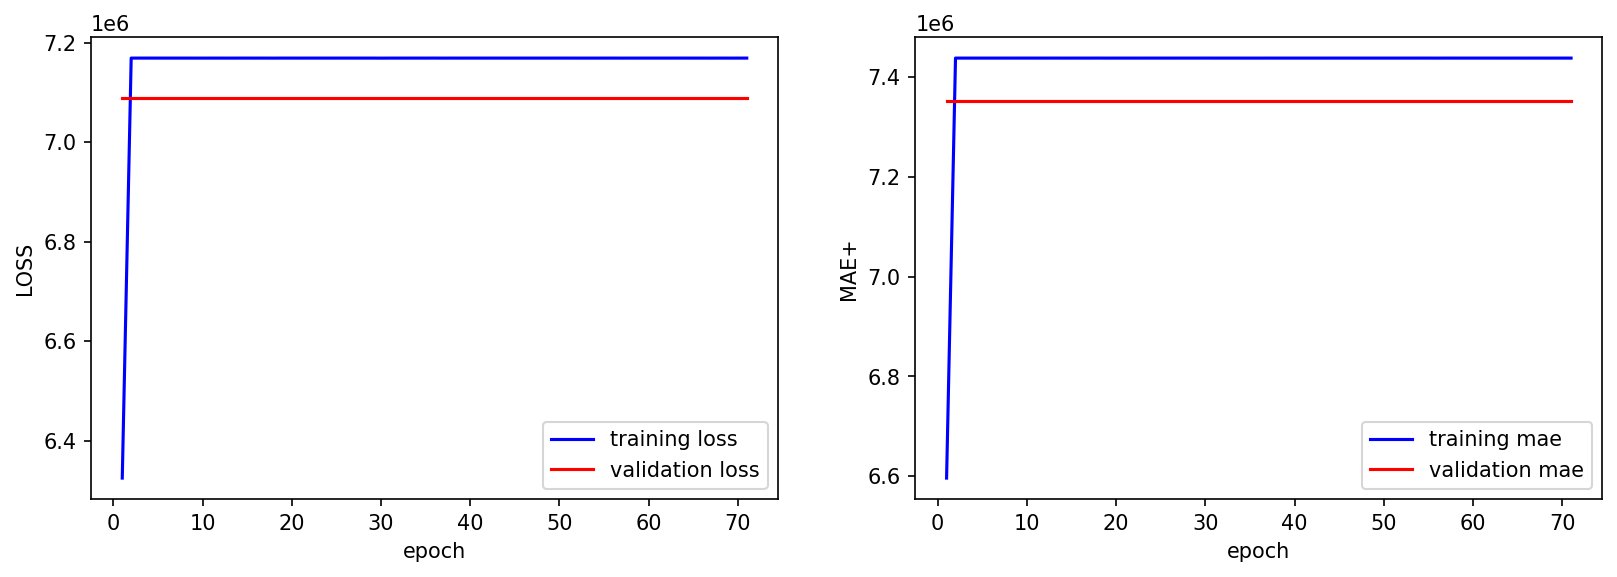

In [13]:
def plot(model):
    epoch_count=range(1, len(model.history['loss']) + 1)
    plt.figure(figsize=(13,4), dpi=150)
    plt.subplot(121)
    plt.plot(epoch_count, model.history['loss'], 'b', label = 'training loss')
    plt.plot(epoch_count, model.history['val_loss'], 'r', label ='validation loss')
    plt.legend()
    plt.ylabel('LOSS')
    plt.xlabel('epoch')
    
    plt.subplot(122)
    plt.plot(epoch_count, model.history['ma_eplus'], 'b', label ='training mae')
    plt.plot(epoch_count, model.history['val_ma_eplus'], 'r', label ='validation mae')
    plt.legend()
    plt.ylabel('MAE+')
    plt.xlabel('epoch')
    plt.savefig('Loss_and_MAE.png')
plot(model)

# <span style="color:blue">7. Loading Model</span>

In [15]:
path='/home/guiomar/Desktop/CODES/DLCODES-VER2/New_Results/Best_weights.weights.h5'
M=U_Net()
model=M.build()
model.load_weights(path)
u_predictions=model.predict(geo_array_tests)

2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


# <span style="color:blue">8. Predictions</span>

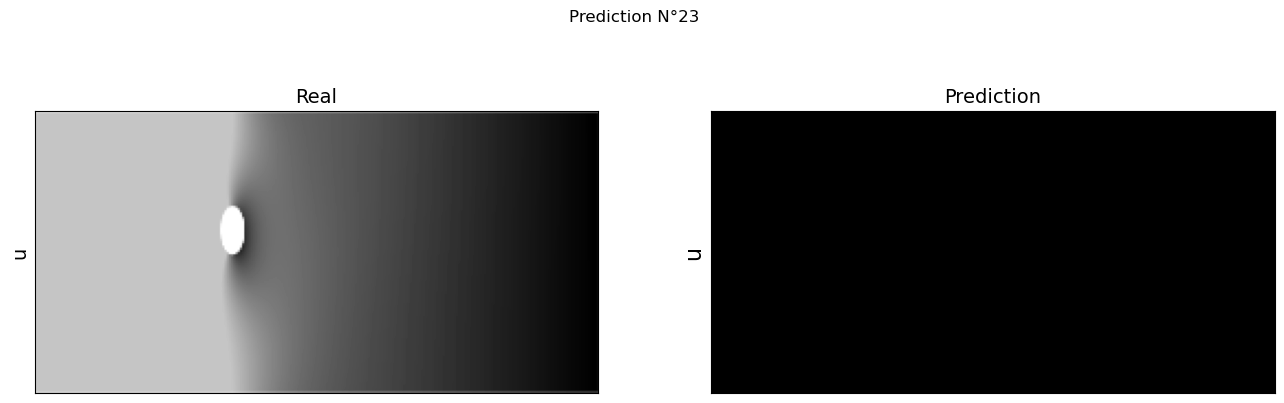

In [16]:
NUM=random.sample(range(1, u_predictions.shape[0]), 1)
plot_data( mag_array_tests[NUM[0]],u_predictions[NUM[0]], title=f"Prediction N°{NUM[0]}",opt='plot')

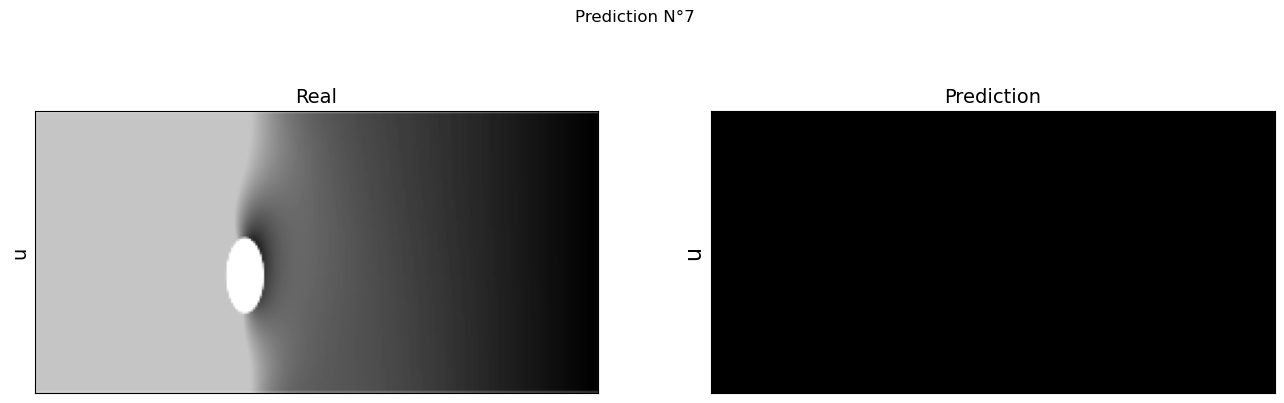

In [17]:
NUM=random.sample(range(1, u_predictions.shape[0]), 1)
plot_data( mag_array_tests[NUM[0]],u_predictions[NUM[0]], title=f"Prediction N°{NUM[0]}",opt='plot')

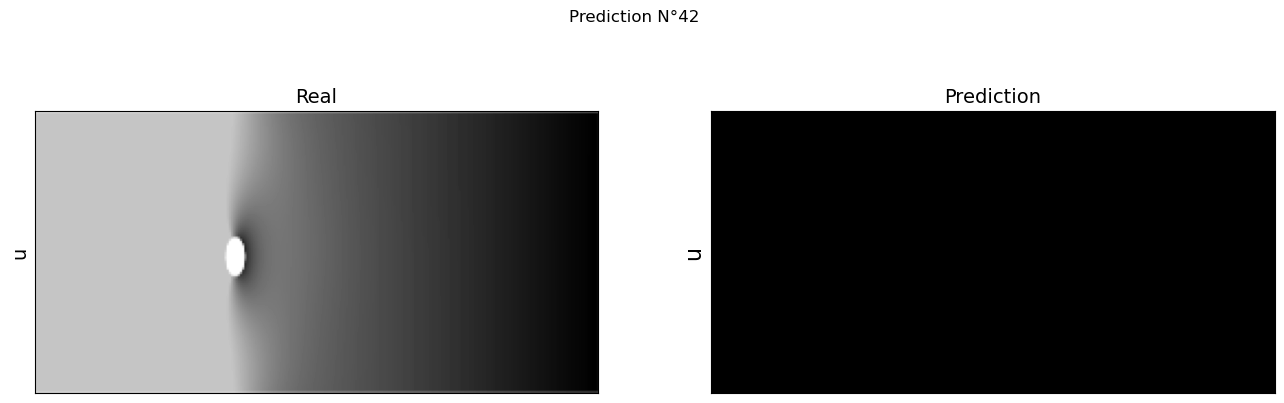

In [18]:
NUM=random.sample(range(1, u_predictions.shape[0]), 1)
plot_data( mag_array_tests[NUM[0]],u_predictions[NUM[0]], title=f"Prediction N°{NUM[0]}",opt='plot')

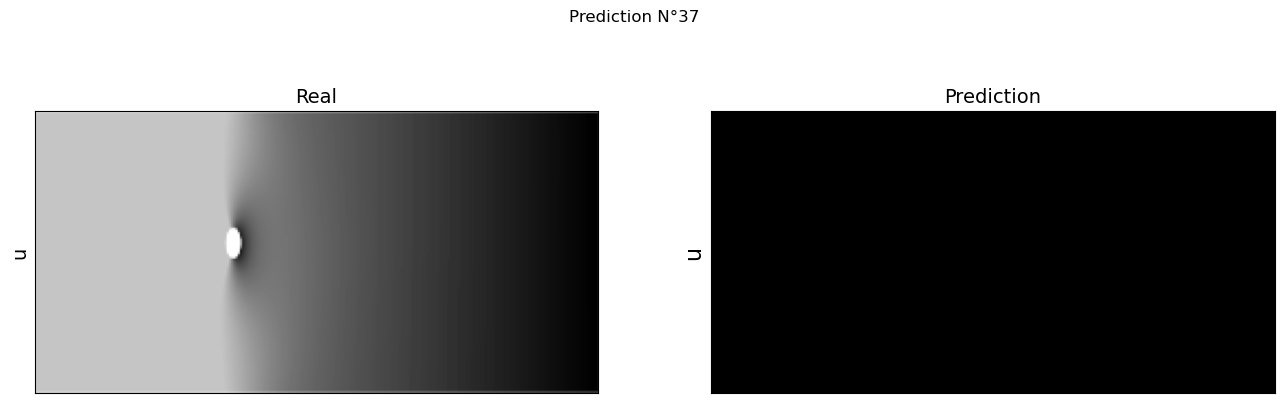

In [19]:
NUM=random.sample(range(1, u_predictions.shape[0]), 1)
plot_data( mag_array_tests[NUM[0]],u_predictions[NUM[0]], title=f"Prediction N°{NUM[0]}",opt='plot')

In [ ]:
'''
def MSEplus2(u_true, u_pred):
    
    Eps=1e-4
    
    # Creating a mask 
    (batch_size,h,w,ch)=u_true.shape
    mask = np.ones((batch_size,h,w,ch)).astype(np.float64) 
    for n in range(batch_size):
        index = np.where(u_true==1) # Indexs of pixeles inside the obstacle where the values are 1. (white) 
        coordinates = list(zip(index [0], index [1]))
        for i,k in enumerate(coordinates):
            mask[n][k[0]][k[1]]=0 # Assign 0 to the pixels inside the obstacle
            
    # Filter pixels outside the obstacle
    u_true_masked = tf.multiply(u_true, mask)  
    u_pred_masked = tf.multiply(u_pred, mask)  

    for batch in range(u_true_masked.shape[0]):
        E_normL2=tf.sqrt(tf.reduce_sum(tf.square(u_true_masked [batch]- u_pred_masked[batch])))
        E=tf.reduce_sum(tf.square(u_true_masked[batch] - u_pred_masked[batch]))
        u_pred_normL2=tf.sqrt(tf.reduce_sum(tf.square(u_pred_masked[batch])))
        #E_normL2 = tf.norm(E, ord='euclidean') 
        mse_loss = E + E_normL2 / (u_pred_normL2 + Eps)
        return mse_loss
'''